In [1]:
import torch
from dataset import ImageDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np
import torch.optim as optim
import torch.nn as nn
import numpy as np
import sys
from vit.vit import VisionTransformer
import time
import pandas as pd
from torchmetrics import Precision, Recall
import warnings
from torchvision.models import resnet18
warnings.filterwarnings('ignore')
import random
from torchvision import transforms
from torchvision.transforms import functional as F
import pandas as pd
import albumentations as A
import time

random.seed(0)
np.random.seed(0)
torch.seed()

transform = A.Compose([
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ], p=0.8),
    A.Rotate(limit=180, p=0.8),
    A.Resize(32, 32)
])

In [2]:
# from torchvision.models import resnet152
# class ResNet152WithDropout(nn.Module):
#     def __init__(self, num_classes=4, dropout_prob=0.5):
#         super(ResNet152WithDropout, self).__init__()
#         resnet = resnet152(pretrained=True)

#         resnet.conv1 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

#         resnet.fc = nn.Sequential(
#             nn.Dropout(p=dropout_prob),
#             nn.Linear(resnet.fc.in_features, num_classes)
#         )



#         self.resnet = resnet

#     def forward(self, x):
#         return self.resnet(x)

# # Create an instance of the model
# model = ResNet152WithDropout(num_classes=4, dropout_prob=0.5)

In [3]:
# model = resnet18()
# model.conv1 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# num_classes = 4
# model.fc = nn.Sequential(
#     nn.Dropout(0.6),  
#     nn.Linear(model.fc.in_features, num_classes)
# )

In [4]:
pd.options.mode.chained_assignment = 'warn'
torch.cuda.empty_cache()


model = VisionTransformer(image_size=32, in_channels=4, num_classes=4, hidden_dims=[64, 64], dropout_rate=0.5)

batch_size = 350

trainset = ImageDataset(data_path='train_data', transform=transform)

trainloader = DataLoader(trainset, batch_size=batch_size,
                         shuffle=True, num_workers=5)


testset =ImageDataset(data_path='validation_data')

testloader = DataLoader(testset, batch_size=batch_size,
                        shuffle=False, num_workers=5)

model = model.to('cuda:0')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay = 0.0008)


precisions = []
precisions_val = []


recalls = []
val_recalls = []

losses = []
val_losses = []



metric_precision = Precision(task="multiclass", num_classes=4, average=None).to('cuda')
metric_recall = Recall(task="multiclass", num_classes=4, average=None).to('cuda')

metric_precision_val = Precision(task="multiclass", num_classes=4, average=None).to('cuda')
metric_recall_val = Recall(task="multiclass", num_classes=4, average=None).to('cuda')

EPOCHS = 100


In [5]:
for epoch in range(EPOCHS):
    recall = []
    precision = []

    recall_val = []
    precision_val = []

    training_loss = 0
    start_time = time.time()
    elapsed_time = 0
    model.train() 
    for i, data in enumerate(trainloader):
        optimizer.zero_grad()
        
        inputs, labels = data
    
        
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')

        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, outputs = torch.max(outputs, 1)
        _, labels = torch.max(labels, 1)


        metric_precision(outputs, labels)
        metric_recall(outputs, labels)



        loss.backward()
        optimizer.step()
        
        training_loss += loss.item()

        if (i + 1) % 10 == 0 or i == len(trainloader) - 1:
            elapsed_time = time.time() - start_time
            batches_done = i + 1
            batches_total = len(trainloader)
            batches_remaining = batches_total - batches_done
            time_per_batch = elapsed_time / batches_done
            estimated_time_remaining = time_per_batch * batches_remaining

            elapsed_time_minutes = elapsed_time / 60
            estimated_time_remaining_minutes = estimated_time_remaining / 60

            progress_message = f'Batch {i}/{len(trainloader)},Remaining: {estimated_time_remaining_minutes:.2f}min'
            sys.stdout.write("\r" + progress_message)
            sys.stdout.flush()

        

 
    model.eval()  
    val_loss = 0
    
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            labels = torch.Tensor(labels)
            inputs = inputs.to('cuda:0')
            labels = labels.to('cuda:0')


            outputs = model(inputs)
            val_loss_crt = criterion(outputs, labels)

            _, outputs = torch.max(outputs, 1)
            _, labels = torch.max(labels, 1)

            metric_precision_val(outputs, labels)
            metric_recall_val(outputs, labels)


            val_loss += val_loss_crt.item()

    precision = metric_precision.compute()
    recall = metric_recall.compute()

    precision_val = metric_precision_val.compute()
    recall_val = metric_recall_val.compute()

    precisions.append(precision)
    precisions_val.append(precision_val)

    recalls.append(recall)
    val_recalls.append(recall_val)
    
    losses.append(training_loss/len(trainloader))
    val_losses.append(val_loss/len(testloader))


    time_epoch = time.time() - start_time
    time_epoch = time_epoch/60

    print(f'Time for epoch:  {time_epoch:2f}min')
    print(f'Epoch {epoch + 1}, Training loss: {training_loss/len(trainloader)} Validation Loss: {val_loss/len(testloader)}')
    
    print(f'Epoch {epoch + 1}, Training Class 1: {precision[0]}, Class 2: {precision[1]}, Class 3: {precision[2]}, Class 4: {precision[3]}')
    print(f'Epoch {epoch + 1}, Validation Class 1: {precision_val[0]}, Class 2: {precision_val[1]}, Class 3: {precision_val[2]}, Class 4: {precision_val[3]}')

    print(f'Epoch {epoch + 1}, Training Class 1: {recall[0]}, Class 2: {recall[1]}, Class 3: {recall[2]}, Class 4: {recall[3]}')
    print(f'Epoch {epoch + 1}, Validation Class 1: {recall_val[0]}, Class 2: {recall_val[1]}, Class 3: {recall_val[2]}, Class 4: {recall_val[3]}')

    

print('Finished Training')
print('Finished Training')


Batch 613/614,Remaining: 0.00minTime for epoch:  1.790563min
Epoch 1, Training loss: 0.9779695187018826 Validation Loss: 0.8715563506791086
Epoch 1, Training Class 1: 0.6380401849746704, Class 2: 0.50334233045578, Class 3: 0.8903225660324097, Class 4: 0.5775488018989563
Epoch 1, Validation Class 1: 0.6585735082626343, Class 2: 0.5493106245994568, Class 3: 0.7965260744094849, Class 4: 0.7582526803016663
Epoch 1, Training Class 1: 0.7648196220397949, Class 2: 0.4335353672504425, Class 3: 0.01991342008113861, Class 4: 0.59935063123703
Epoch 1, Validation Class 1: 0.8493602871894836, Class 2: 0.6143770813941956, Class 3: 0.10808081179857254, Class 4: 0.5143097639083862
Batch 613/614,Remaining: 0.00minTime for epoch:  1.790543min
Epoch 2, Training loss: 0.8516771709880145 Validation Loss: 0.8491212463740146
Epoch 2, Training Class 1: 0.6665750741958618, Class 2: 0.535844624042511, Class 3: 0.8051391839981079, Class 4: 0.6197177171707153
Epoch 2, Validation Class 1: 0.6375351548194885, Class

In [6]:
model_name = "vision_transformer10"
torch.save(model.state_dict(),f'models/{model_name}.pth')
df = pd.DataFrame()
df['loss'] = np.array(losses)
df['val_loss'] = np.array(val_losses)

df['recall'] = [list(recall.cpu().numpy()) for recall in recalls]
df['val_recall'] = [list(val_recall.cpu().numpy()) for val_recall in val_recalls]

df['precision'] = [list(precision.cpu().numpy()) for precision in precisions] 
df['val_precision'] = [list(val_precision.cpu().numpy()) for val_precision in precisions_val]

df.to_csv(f'results/{model_name}.csv', index=False)

In [7]:
df = pd.read_csv('results/vision_transformer10.csv')
df.head()

,loss,val_loss,recall,val_recall,precision,val_precision
0,0.977970,0.871556,"[0.7648196, 0.43353537, 0.01991342, 0.59935063]","[0.8493603, 0.6143771, 0.10808081, 0.51430976]","[0.6380402, 0.50334233, 0.89032257, 0.5775488]","[0.6585735, 0.5493106, 0.7965261, 0.7582527]"
1,0.851677,0.849121,"[0.7703319, 0.49673882, 0.054256853, 0.626277]","[0.87367004, 0.58319867, 0.14141414, 0.5229461]","[0.6665751, 0.5358446, 0.8051392, 0.6197177]","[0.63753515, 0.56791097, 0.58292854, 0.77081317]"
2,0.812445,0.782882,"[0.7748581, 0.52253485, 0.0975469, 0.63959116]","[0.866083, 0.5838047, 0.1741863, 0.56147027]","[0.6806363, 0.55269796, 0.68629444, 0.63835984]","[0.65191644, 0.58153343, 0.63711, 0.758502]"
3,0.791839,0.757413,"[0.77795094, 0.53766596, 0.13841991, 0.6492496]","[0.8554461, 0.5817761, 0.23181818, 0.59515995]","[0.6898021, 0.565273, 0.64934844, 0.649423]","[0.6676192, 0.59350127, 0.5857082, 0.7450317]"
4,0.777375,0.747376,"[0.7805281, 0.54770565, 0.16761905, 0.65676767]","[0.8482222, 0.5795286, 0.25824916, 0.62112457]","[0.6966757, 0.5743999, 0.6360749, 0.656925]","[0.6785997, 0.6031383, 0.58809996, 0.7348215]"


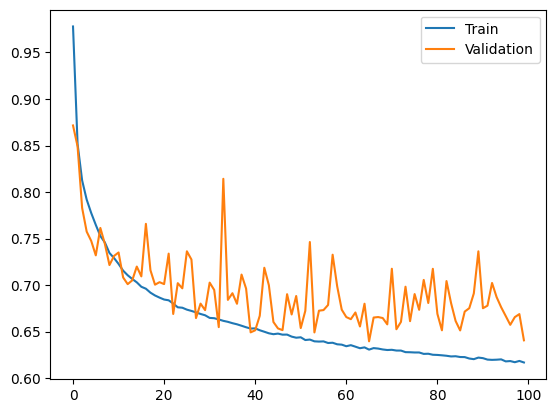

In [8]:
plt.plot(df['loss'], label='Train')
plt.plot(df['val_loss'], label='Validation')
plt.legend()
plt.show()

In [63]:
!nvidia-smi

Sun Mar  3 21:21:54 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.61                 Driver Version: 551.61         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| 30%   44C    P2             65W /  246W |    2227MiB /  12282MiB |     38%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----